0. Code Introduction: <br>
0.1 Three phase optimal power flow <br>
0.2 Mobile DG and BESS allocation <br>
0.3 Extend the silumation time step from 24 to 96 will significantly increase the computational time, so keep nT = 24 <br>
0.4 Set tripped lines. Define new binary variables to indicate the on/off status of distribution lines. <br>
0.5 Change the objective function to unserved load. <br>
0.6 Add repair crew schedule. <br>
0.7 Reduce the number of mobile energy resources. <br>
0.8 Set nMBESS = 2, nMDG = 2, nRC = 1, test the results of repair crew schedule.  <br>
0.9 Enlarge the transportation system to 18*18 <br>
0.10 Set seperate grid connection set for MBESS and MDG <br>
0.11 Debug the MBESS issue <br>
0.12 Change the method that obtaining MBESS and MDG grid connection node <br> 
0.13 Set the outage start time as t = 5:00 AM <br>
0.14 Do not consider MER: set the MER rated power to 0 <br>

In [8]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import random
from itertools import combinations

1. Read system data

In [9]:
df_bus = pd.read_excel('IEEE33-bus.xlsx')
df_branch = pd.read_excel('IEEE33-branch.xlsx')
Vbase = 12.66 # base voltage is 12.66 kV
Sbase = 1     # base power is 1 MW

Pd = df_bus.loc[:,['Pa', 'Pb', 'Pc']].values/(Sbase*1000)
Qd = df_bus.loc[:,['Qa', 'Qb', 'Qc']].values/(Sbase*1000)
r = df_branch.loc[:,'raa':'rbc'].values/(Vbase**2/Sbase)
x = df_branch.loc[:,'xaa':'xbc'].values/(Vbase**2/Sbase)

r = r[0:32, :]
x = x[0:32, :]

# number of different sets
nL = len(r)     # number of lines
nB = len(Pd) # number of buses
nP = 3          # number of phases
nT = 24         # number of time intervals

Pload_trend = np.array([1228.932, 1157.113, 1117.32, 1107.84, 1129.831, 1177.072, 1259.551, 1346.199, 1456.801, 1592.46, 1721.174, 1875.908,
                        1965.402, 2019.949, 2071.7, 2133.75, 2155.312, 2114.513, 2064.977, 1959.087, 1878.477, 1749.831, 1582.543, 1344.039])
LMP = np.array([20.97, 17.35, 15.81, 15.21, 14.13, 13.06, 15.02, 17.17, 19.18, 20.9, 22.54, 25.33, 
                27.41, 29.69, 32.25, 33.53, 36.37, 37.61, 41.24, 35.45, 32.4, 30.58, 27.87, 23.32])
maxP = np.max(Pload_trend)
Pload_trend = Pload_trend/maxP*2
Pload = np.zeros((nB, nP, nT))
Qload = np.zeros((nB, nP, nT))
for t in range(nT):
    Pload[:,:,t] = Pd * Pload_trend[t]
    Qload[:,:,t] = Qd * Pload_trend[t]

2. Power system parameters definition

In [10]:
# marginal price
pi_g = 30
pi_mt = 50
pi_pv = 5
V0 = 1.0
pf = 0.3287; # cos(theta) = 0.95
PV_fore = 0.2*np.array([0, 0, 0, 0, 0, 0, 0.04, 0.15, 0.24, 0.33, 0.43, 0.48, 0.50, 0.48, 0.43, 0.32, 0.22, 0.13, 0.01, 0, 0, 0, 0, 0])

MT_max = 0.3 # the capacity at single phase 
CB_max = 0.3 # the capacity at single phase

# DER locations
PV_loc = [x - 1 for x in [11]]
MT_loc = [x - 1 for x in [18]]
CB_loc = [x - 1 for x in [10]]
# generation limits and voltage limits
Pmin = np.zeros((nB, nP, nT))
Pmax = np.zeros((nB, nP, nT))
Qmin = np.zeros((nB, nP, nT))
Qmax = np.zeros((nB, nP, nT))
# thermal limit of distribution lines
Smax = 10*np.ones((nL, nP, nT))
# 3D min/max power output constraints
for t in range(nT):
    for phi in range(nP):
        Pmin[0, phi, t] = -30
        Pmax[[0] + PV_loc + MT_loc, phi, t] = [30, PV_fore[t], MT_max/3]
        Qmin[[0] + PV_loc + MT_loc + CB_loc, phi, t] = [-30, -pf*PV_fore[t], -pf*MT_max/3, 0]
        Qmax[[0] + PV_loc + MT_loc + CB_loc, phi, t] = [30, pf*PV_fore[t], pf*MT_max/3, CB_max/3]

# form bus_branch matrix E
E = np.zeros((nB, nL))
for i in range(nL):
    fbus = df_branch.iloc[i,0]
    tbus = df_branch.iloc[i,1]
    E[int(fbus)-1,i] = 1
    E[int(tbus)-1,i] = -1
Etrans = E.T

# Three phase impedance
R = np.zeros((nL, nP, nP))
X = np.zeros((nL, nP, nP))
for i in range(nL):
    R[i,:,:] = np.array([[r[i,0], -0.5*r[i,3] + np.sqrt(3)/2*x[i,3], -0.5*r[i,4] - np.sqrt(3)/2*x[i,4]],
                         [-0.5*r[i,3] - np.sqrt(3)/2*x[i,3], r[i,1], -0.5*r[i,5] + np.sqrt(3)/2*x[i,5]],
                         [-0.5*r[i,4] + np.sqrt(3)/2*x[i,4], -0.5*r[i,5] - np.sqrt(3)/2*x[i,5], r[i,2]]
                         ])
    X[i,:,:] = np.array([[x[i,0], -np.sqrt(3)/2*r[i,3] - 0.5*x[i,3], np.sqrt(3)/2*r[i,4] - 0.5*x[i,4]],
                         [np.sqrt(3)/2*r[i,3] - 0.5*x[i,3], x[i,1], -np.sqrt(3)/2*r[i,5] - 0.5*x[i,5]],
                         [-np.sqrt(3)/2*r[i,4] - 0.5*x[i,4], np.sqrt(3)/2*r[i,5] - 0.5*x[i,5], x[i,2]]
                         ])

3. Transportation system constant parameters definition

In [11]:
# Connection_Node = np.array([3, 5, 6, 8, 10, 11, 13, 14, 16, 18, 20, 22, 24, 26, 27, 28, 30, 32], dtype=int)
Connection_Node = np.array([3, 5, 6, 8, 10, 11, 13, 14, 16, 18, 20, 22, 24, 26, 27, 28, 30, 32], dtype=int) # , 18, 20, 22, 24, 26, 27, 28, 30, 32
nConnect = len(Connection_Node)
# Travel_Time = np.zeros((nConnect, nConnect))
# for i in range(nConnect):
#       for j in range(i+1, nConnect):
#             Travel_Time[i,j] = random.randint(1, 2)
#             Travel_Time[j,i] = Travel_Time[i,j]
# Travel_Time = Travel_Time.astype(int) 
# 
Travel_Time = np.array([[0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1], 
                        [2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1],
                        [2, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1],
                        [2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1],
                        [1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1],
                        [1, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1],
                        [1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1],
                        [1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1],
                        [1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1],
                        [1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1],
                        [2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1],
                        [2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1],
                        [1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1],
                        [1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1],
                        [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1],                        
                        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0]                        
                        ])  

# original grid connection node, [7, 9, 10, 12], [8, 9, 11, 12]
nConnect_MBESS = 10
nConnect_MDG = 11
Travel_Time_MBESS = Travel_Time[0:nConnect_MBESS, 0:nConnect_MBESS]
Travel_Time_MDG = Travel_Time[(nConnect-nConnect_MDG):(nConnect), (nConnect-nConnect_MDG):(nConnect)]
connection_Node_MBESS = Connection_Node[0:nConnect_MBESS]
connection_Node_MDG = Connection_Node[(nConnect-nConnect_MDG):(nConnect)]
MBESS_MDG_intersection = np.intersect1d(connection_Node_MBESS, connection_Node_MDG)
MBESS_MDG_union = np.union1d(connection_Node_MBESS, connection_Node_MDG)
con_Node_MBESS_only = np.setdiff1d(connection_Node_MBESS, MBESS_MDG_intersection)
con_Node_MDG_only = np.setdiff1d(connection_Node_MDG, MBESS_MDG_intersection)

# # Transportatin parameters
Cap = 1 # the maximum number of DGs and BESSs that can connect to the same node
# Transportation modeling
# Mobile BESS
nMBESS = 1
MBESS_MWrated = [0.0] * nMBESS # all in p.u.
MBESS_MWhrated = [0.0] * nMBESS
MBESS_Ini_MWh = [0.0] * nMBESS
# Mobile DG
nMDG = 2 # number of MDG
MDG_Pmin = [0] * nMDG
MDG_Pmax = [0.0] * nMDG
MDG_Qmin = [0] * nMDG
MDG_Qmax = [0] * nMDG
# Mobile resource variables
yita = 0.9
delta_t = 1

4. Repair crew parameters

In [12]:
Cap_CR = 1 # the maximum number of repair crews that can repair a faulted line

# Travel_Time_RC = np.zeros((nTL+1, nTL+1))
# for i in range(nTL+1):
#       for j in range(i+1, nTL+1):
#             Travel_Time_RC[i,j] = random.randint(1, 2)
#             Travel_Time_RC[j,i] = Travel_Time_RC[i,j]
# Travel_Time_RC = Travel_Time_RC.astype(int)  

Travel_Time_RC = np.array([ [0, 1, 2, 1, 2, 2, 2, 1], 
                            [1, 0, 2, 2, 1, 2, 2, 1], 
                            [2, 2, 0, 2, 1, 2, 1, 2], 
                            [1, 2, 2, 0, 1, 2, 1, 2], 
                            [2, 1, 1, 1, 0, 2, 1, 2], 
                            [2, 2, 2, 2, 2, 0, 2, 1], 
                            [2, 2, 1, 1, 1, 2, 0, 1],
                            [1, 1, 2, 2, 2, 1, 1, 1]])

# Transportation modeling
nRC = 2 
Trepair = [4, 6, 5, 4] # working time of each faulted line, [4, 4, 5, 4, 3, 4, 4]

3. Define optimization problem

In [13]:
def solve_optimization(tripped_lines):
    m = gp.Model()
    
    # Define variables
    nTL = len(tripped_lines) 
    big_M = 10e3
    Pd_shed = m.addVars(nB, nP, nT, vtype = GRB.CONTINUOUS, name = 'Pd_shed')
    Qd_shed = m.addVars(nB, nP, nT, vtype = GRB.CONTINUOUS, name = 'Qd_shed')
    Pl = m.addVars(nL, nP, nT, vtype = GRB.CONTINUOUS, lb = -10, ub = 10, name = 'Pl')
    Ql = m.addVars(nL, nP, nT, vtype = GRB.CONTINUOUS, lb = -10, ub = 10, name = 'Ql')
    V = m.addVars(nB, nP, nT, vtype = GRB.CONTINUOUS, name = 'V')
    Pg = m.addVars(nB, nP, nT, vtype = GRB.CONTINUOUS, lb = -10, ub = 10, name = 'Pg')
    Qg = m.addVars(nB, nP, nT, vtype = GRB.CONTINUOUS, lb = -10, ub = 10, name = 'Qg')
    gamma = m.addVars(nTL, nT, vtype = GRB.BINARY, name  = 'gamma') # indicating the on/off status of a distribution line
    deltaV = m.addVars(nTL, nT, vtype = GRB.CONTINUOUS, name  = 'deltaV') # slack variable 
    
    # Define constraints
    # power output limits
    m.addConstrs(Qg[i,phi,t] <= pf*Pg[i,phi,t] for i in MT_loc for phi in range(nP) for t in range(nT))
    m.addConstrs(Qg[i,phi,t] >= -pf*Pg[i,phi,t] for i in MT_loc for phi in range(nP) for t in range(nT))
    # power flow calculation
    m.addConstrs((Pg[j,phi,t] - Pload[j,phi,t] + Pd_shed[j,phi,t] == gp.quicksum(E[j,i]*Pl[i,phi,t] for i in range(nL)) for j in range(nB) for phi in range(nP) for t in range(nT)), 'PNodal')
    m.addConstrs((Qg[j,phi,t] - Qload[j,phi,t] + Qd_shed[j,phi,t] == gp.quicksum(E[j,i]*Ql[i,phi,t] for i in range(nL)) for j in range(nB) for phi in range(nP) for t in range(nT)), 'QNodal')
    # load shedding constraints
    m.addConstrs((Pd_shed[j,phi,t] <= Pload[j,phi,t] for j in range(nB) for phi in range(nP) for t in range(nT)))
    m.addConstrs((Qd_shed[j,phi,t] <= Qload[j,phi,t] for j in range(nB) for phi in range(nP) for t in range(nT)))
    # distribution line thermal limits
    m.addConstrs((np.sqrt(3)*Pl[i,phi,t] + Ql[i,phi,t] <= 2*Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    m.addConstrs((np.sqrt(3)*Pl[i,phi,t] + Ql[i,phi,t] >= -2*Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    m.addConstrs((np.sqrt(3)*Pl[i,phi,t] - Ql[i,phi,t] <= 2*Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    m.addConstrs((np.sqrt(3)*Pl[i,phi,t] - Ql[i,phi,t] >= -2*Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    m.addConstrs((Pl[i,phi,t] <= Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    m.addConstrs((Pl[i,phi,t] >= -Smax[i,phi,t] for i in range(nL) for phi in range(nP) for t in range(nT)))
    
    # line thermal limits of tripped lines
    for j in range(nTL):
        i = tripped_lines[j]
        m.addConstrs((np.sqrt(3)*Pl[i,phi,t] + Ql[i,phi,t] <= 2*gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
        m.addConstrs((np.sqrt(3)*Pl[i,phi,t] + Ql[i,phi,t] >= -2*gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
        m.addConstrs((np.sqrt(3)*Pl[i,phi,t] - Ql[i,phi,t] <= 2*gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
        m.addConstrs((np.sqrt(3)*Pl[i,phi,t] - Ql[i,phi,t] >= -2*gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
        m.addConstrs((Pl[i,phi,t] <= gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
        m.addConstrs((Pl[i,phi,t] >= -gamma[j,t]*Smax[i,phi,t] for phi in range(nP) for t in range(nT)))
    
    # m.addConstrs((Pl[i]*Pl[i] + Ql[i]*Ql[i] <= S[i]*S[i] for i in range(nl)), 'S_max')
    # m.addConstrs((np.square(Pl[i]-R[i]*l[i]) + np.square(Ql[i]-X[i]*l[i]) <= S[i]*S[i] for i in range(nl)), 'S_max2')
    
    # voltage calculation for normal ines 
    nNL = [i for i in range(nL) if i not in tripped_lines] # set of normal lines
    for i in nNL:
        for t in range(nT):
            for phi in range(nP):
                m.addConstr(((gp.quicksum(Etrans[i,j]*V[j,phi,t] for j in range(nB))) == 2*gp.quicksum((R[i,phi,k]*Pl[i,k,t] + X[i,phi,k]*Ql[i,k,t]) for k in range(nP))), 'V') # 
    # voltage calculation for tripped ines, slack variable deltaV is added
    for l in range(nTL):
        i = tripped_lines[l]
        for t in range(nT):
            m.addConstr((deltaV[l,t] <= big_M*(1-gamma[l,t])))
            m.addConstr((deltaV[l,t] >= -big_M*(1-gamma[l,t])))
            for phi in range(nP):
                m.addConstr(((gp.quicksum(Etrans[i,j]*V[j,phi,t] for j in range(nB))) == deltaV[l,t] + 2*gp.quicksum((R[i,phi,k]*Pl[i,k,t] + X[i,phi,k]*Ql[i,k,t]) for k in range(nP))), 'V') # 
    # voltage constraints
    for index in range(1):
        m.addConstrs((V[0,phi,t] == V0**2 for phi in range(nP) for t in range(nT)), 'V0')
        m.addConstrs((V[j,phi,t] <= 1.1**2 for j in range(nB) for phi in range(nP) for t in range(nT)), 'Vmax')
        m.addConstrs((V[j,phi,t] >= 0.9**2 for j in range(nB) for phi in range(nP) for t in range(nT)), 'Vmin')
        m.addConstrs((gamma[i,t] == 1 for i in range(nTL) for t in range(t_fault_start)))      

    # Transportation constraints    
    yMBESS = m.addVars(nMBESS, nConnect_MBESS, nT, vtype = GRB.BINARY, name = 'yMBESS')
    zMBESS = m.addVars(nMBESS, nT, vtype = GRB.BINARY, name = 'zMBESS')
    Pdis = m.addVars(nMBESS, nConnect_MBESS, nT, vtype = GRB.CONTINUOUS, name = 'Pdis')
    Pcha = m.addVars(nMBESS, nConnect_MBESS, nT, vtype = GRB.CONTINUOUS, name = 'Pcha')
    EMBESS = m.addVars(nMBESS, nT+1, vtype = GRB.CONTINUOUS, name = 'Pcha')
    
    yMDG = m.addVars(nMDG, nConnect_MDG, nT, vtype = GRB.BINARY, name = 'yMDG')
    zMDG = m.addVars(nMDG, nT, vtype = GRB.BINARY, name = 'zMDG')     
    
    m.addConstrs(((gp.quicksum(yMBESS[k,i,t] for i in range(nConnect_MBESS)) <= 1) for k in range(nMBESS) for t in range(nT)))
    m.addConstrs(((gp.quicksum(yMBESS[k,i,t] for i in range(nConnect_MBESS)) + zMBESS[k,t] == 1) for k in range(nMBESS) for t in range(nT)))
    m.addConstrs(((gp.quicksum(yMDG[k,i,t] for i in range(nConnect_MDG)) <= 1) for k in range(nMDG) for t in range(nT)))
    m.addConstrs(((gp.quicksum(yMDG[k,i,t] for i in range(nConnect_MDG)) + zMDG[k,t] == 1) for k in range(nMDG) for t in range(nT)))
    m.addConstrs(((gp.quicksum(yMBESS[k,i,t] for k in range(nMBESS)) <= Cap) for i in range(nConnect_MBESS) for t in range(nT)))
    m.addConstrs(((gp.quicksum(yMDG[k,i,t] for k in range(nMDG)) <= Cap) for i in range(nConnect_MDG) for t in range(nT)))
    
    for i in MBESS_MDG_intersection:
        j1 = np.where(connection_Node_MBESS == i)[0][0]
        j2 = np.where(connection_Node_MDG == i)[0][0]
        m.addConstrs(((gp.quicksum(yMBESS[k,j1,t] for k in range(nMBESS)) + gp.quicksum(yMDG[k,j2,t] for k in range(nMDG)) <= Cap) for t in range(nT)))
    
    for k in range(nMBESS):
        for j in range(nConnect_MBESS):
            for i in range(nConnect_MBESS):
                for t in range(nT):
                    if i != j:    
                        for tao in range(1, Travel_Time_MBESS[i,j]+1):
                            if t + tao <= nT-1:
                                m.addConstr((yMBESS[k,i,t+tao] + yMBESS[k,j,t] <= 1))
    
    for k in range(nMDG):
        for j in range(nConnect_MDG):
            for i in range(nConnect_MDG):
                for t in range(nT):
                    if i != j:    
                        for tao in range(1, Travel_Time_MDG[i,j]+1):
                            if t + tao <= nT-1:
                                m.addConstr((yMDG[k,i,t+tao] + yMDG[k,j,t] <= 1))
    
    # Assume each MBESS and DG connects to a node in three phases, and each phase has the same power input
    m.addConstrs((EMBESS[k,0] == MBESS_Ini_MWh[k] for k in range(nMBESS)))
    m.addConstrs((EMBESS[k,t+1] == EMBESS[k,t] + gp.quicksum((delta_t*Pcha[k,i,t]*np.sqrt(yita) - delta_t*Pdis[k,i,t]/np.sqrt(yita)) for i in range(nConnect_MBESS)) for k in range(nMBESS) for t in range(nT)))
    m.addConstrs((EMBESS[k,t+1] <= MBESS_MWhrated[k]*0.9 for k in range(nMBESS) for t in range(nT))) # SOC constraints
    m.addConstrs((EMBESS[k,t+1] >= MBESS_MWhrated[k]*0.1 for k in range(nMBESS) for t in range(nT)))
    
    m.addConstrs((Pcha[k,i,t] <= MBESS_MWrated[k]*yMBESS[k,i,t]) for k in range(nMBESS) for i in range(nConnect_MBESS) for t in range(nT)) # charging and discharging constraints
    m.addConstrs((Pcha[k,i,t] >= 0) for k in range(nMBESS) for i in range(nConnect_MBESS) for t in range(nT))
    m.addConstrs((Pdis[k,i,t] <= MBESS_MWrated[k]*yMBESS[k,i,t]) for k in range(nMBESS) for i in range(nConnect_MBESS) for t in range(nT))
    m.addConstrs((Pdis[k,i,t] >= 0) for k in range(nMBESS) for i in range(nConnect_MBESS) for t in range(nT))
    
    for node in con_Node_MBESS_only:
        for t in range(nT):
            i = np.where(connection_Node_MBESS == node)[0][0]
            power_MBESS = gp.quicksum((Pdis[k,i,t] - Pcha[k,i,t])/3.0 for k in range(nMBESS))
            m.addConstrs((Pg[node,phi,t] == power_MBESS for phi in range(nP)))
            m.addConstrs((Qg[node,phi,t] == 0 for phi in range(nP)))
        
    for node in con_Node_MDG_only:
        for t in range(nT):
            i = np.where(connection_Node_MDG == node)[0][0]
            m.addConstrs((Pg[node,phi,t] >= gp.quicksum(MDG_Pmin[k]*yMDG[k,i,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Pg[node,phi,t] <= gp.quicksum(MDG_Pmax[k]*yMDG[k,i,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Qg[node,phi,t] >= gp.quicksum(MDG_Qmin[k]*yMDG[k,i,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Qg[node,phi,t] <= gp.quicksum(MDG_Qmax[k]*yMDG[k,i,t]/3.0 for k in range(nMDG)) for phi in range(nP)))      
    
    for node in MBESS_MDG_intersection:
        for t in range(nT):
            j1 = np.where(connection_Node_MBESS == node)[0][0]
            j2 = np.where(connection_Node_MDG == node)[0][0]
            power_MBESS = gp.quicksum((Pdis[k,j1,t] - Pcha[k,j1,t])/3.0 for k in range(nMBESS))
            m.addConstrs((Pg[node,phi,t] >= power_MBESS + gp.quicksum(MDG_Pmin[k]*yMDG[k,j2,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Pg[node,phi,t] <= power_MBESS + gp.quicksum(MDG_Pmax[k]*yMDG[k,j2,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Qg[node,phi,t] >= gp.quicksum(MDG_Qmin[k]*yMDG[k,j2,t]/3.0 for k in range(nMDG)) for phi in range(nP)))
            m.addConstrs((Qg[node,phi,t] <= gp.quicksum(MDG_Qmax[k]*yMDG[k,j2,t]/3.0 for k in range(nMDG)) for phi in range(nP)))     

    # Add power ouput limit
    for index in range(1):
        nB_remain = [i for i in range(nB) if i not in MBESS_MDG_union]
        m.addConstrs((Pg[i,phi,t] >= Pmin[i,phi,t]) for i in nB_remain for phi in range(nP) for t in range(nT)) 
        m.addConstrs((Pg[i,phi,t] <= Pmax[i,phi,t]) for i in nB_remain for phi in range(nP) for t in range(nT)) 
        m.addConstrs((Qg[i,phi,t] >= Qmin[i,phi,t]) for i in nB_remain for phi in range(nP) for t in range(nT)) 
        m.addConstrs((Qg[i,phi,t] <= Qmax[i,phi,t]) for i in nB_remain for phi in range(nP) for t in range(nT)) 

    # Repair crew constraints
    yRC = m.addVars(nRC, nTL+1, nT, vtype = GRB.BINARY, name = 'yRC')
    zRC = m.addVars(nRC, nT, vtype = GRB.BINARY, name = 'zRC')
    xRC = m.addVars(nRC, nTL, nT, vtype = GRB.BINARY, name = 'xRC')
    m.addConstrs((yRC[0,0,t] == 1 for t in range(t_fault_start))) # repair crew are located in the depot (depot location is 0) at t = 0
    m.addConstrs((yRC[1,0,t] == 1 for t in range(t_fault_start))) 
    # m.addConstrs((yRC[2,0,t] == 1 for t in range(t_fault_start)))
    # m.addConstrs((yRC[3,0,t] == 1 for t in range(t_fault_start)))
    
    m.addConstrs(((gp.quicksum(yRC[k,i,t] for i in range(nTL+1)) <= 1) for k in range(nRC) for t in range(t_fault_start, nT)))
    m.addConstrs(((gp.quicksum(yRC[k,i,t] for i in range(nTL+1)) + zRC[k,t] == 1) for k in range(nRC) for t in range(t_fault_start, nT)))
    m.addConstrs(((gp.quicksum(yRC[k,i,t] for k in range(nRC)) <= Cap_CR) for i in range(nTL+1) for t in range(t_fault_start, nT))) # repair crew can be at same depot intially
    
    for k in range(nRC):
        for j in range(nTL+1):
            for i in range(nTL+1):
                for t in range(0, nT):
                    if i != j:    
                        for tao in range(1, Travel_Time_RC[i,j]+1):
                            if t + tao <= nT-1:
                                m.addConstr((yRC[k,i,t+tao] + yRC[k,j,t] <= 1))
    
    # Shunbo's formulation
    for j in range(nTL):
        for t in range(t_fault_start, nT):
            for k in range(nRC):
                m.addConstr((xRC[k,j,t] <= gp.quicksum(yRC[k,j+1,tao] for tao in range(t_fault_start, t))/Trepair[j]))
                if t < nT-1:
                    m.addConstr((xRC[k,j,t] <= xRC[k,j,t+1]))
            m.addConstr((gamma[j,t] <= gp.quicksum(xRC[k,j,t] for k in range(nRC))))
            if t < nT-1:
                m.addConstr((gamma[j,t] <= gamma[j,t+1]))  

    # Define objective
    # total_cost = gp.quicksum((LMP[t]*Pg[0, phi, t] + pi_mt*gp.quicksum(Pg[i, phi, t] for i in MT_loc) + pi_pv*gp.quicksum(Pg[i, phi, t] for i in PV_loc)) for phi in range(nP) for t in range(nT))
    total_shed = gp.quicksum(Pd_shed[j,phi,t] + Qd_shed[j,phi,t] for j in range(nB) for phi in range(nP) for t in range(nT))
    total_fuel = 0.00001*gp.quicksum((yRC[k, j, t] for k in range(nRC) for j in range(nTL+1) for t in range(nT))) + \
                 0.00001*gp.quicksum((yMDG[k, j, t] for k in range(nMDG) for j in range(nConnect_MDG) for t in range(nT))) + \
                 0.00000001*gp.quicksum((yMBESS[k, j, t] for k in range(nMBESS) for j in range(nConnect_MBESS) for t in range(nT)))
    total_obj = total_shed + total_fuel
    m.setObjective(total_obj, GRB.MINIMIZE)  
    m.optimize()
    print('total unserved load:', m.objVal)       


    # Get optimization results
    v_val = np.zeros((nB, nP, nT))
    Pg_val = np.zeros((nB, nP, nT))
    Qg_val = np.zeros((nB, nP, nT))
    Pd_shed_val = np.zeros((nB, nP, nT))
    Qd_shed_val = np.zeros((nB, nP, nT))
    Pl_val = np.zeros((nL, nP, nT))
    Ql_val = np.zeros((nL, nP, nT))
    for j in range(nB):
        for phi in range(nP):
            for t in range(nT):
                v_val[j, phi, t] = np.sqrt(V[j, phi, t].x)
                Pg_val[j, phi, t] = Pg[j, phi, t].x
                Qg_val[j, phi, t] = Qg[j, phi, t].x
                Pd_shed_val[j, phi, t] = Pd_shed[j, phi, t].x
                Qd_shed_val[j, phi, t] = Qd_shed[j, phi, t].x

    for j in range(nL):
        for phi in range(nP):
            for t in range(nT):
                Pl_val[j, phi, t] = Pl[j, phi, t].x
                Ql_val[j, phi, t] = Ql[j, phi, t].x    
                
    yMDG_val = np.zeros((nMDG, nConnect_MDG, nT))
    zMDG_val = np.zeros((nMDG, nT))
    PMDG_val = np.zeros((nMDG, nConnect_MDG, nT))
    for k in range(nMDG):
        for i in range(nConnect_MDG):
            for t in range(nT):
                yMDG_val[k,i,t] = yMDG[k,i,t].x
                # PMDG_val[k,i,t] = pMDG[k,i,t].x

    for k in range(nMDG):
        for t in range(nT):
            zMDG_val[k,t] = zMDG[k,t].x  

    yMBESS_val = np.zeros((nMBESS, nConnect_MBESS, nT))
    EMBESS_val = np.zeros((nMBESS, nT))
    PMBESS_val = np.zeros((nMBESS, nConnect_MBESS, nT))
    Pdis_val = np.zeros((nMBESS, nConnect_MBESS, nT))
    Pcha_val = np.zeros((nMBESS, nConnect_MBESS, nT))
    for k in range(nMBESS):
        for i in range(nConnect_MBESS):
            for t in range(nT):
                yMBESS_val[k,i,t] = yMBESS[k,i,t].x
                Pdis_val[k,i,t] = Pdis[k,i,t].x
                Pcha_val[k,i,t] = Pcha[k,i,t].x
                PMBESS_val[k,i,t] = Pdis[k,i,t].x - Pcha[k,i,t].x
                EMBESS_val[k,t] = EMBESS[k,t].x   
                
    yRC_val = np.zeros((nRC, nTL+1, nT))
    zRC_val = np.zeros((nRC, nT))
    gamma_val = np.zeros((nTL, nT))
    for k in range(nRC):
        for i in range(nTL+1):
                for t in range(nT):
                    yRC_val[k,i,t] = yRC[k,i,t].x

    for k in range(nRC):
        for t in range(nT):
                zRC_val[k,t] = zRC[k,t].x

    for k in range(nTL):
        for t in range(nT):
            gamma_val[k,t] = gamma[k,t].x

    P_bus_shed = [sum(Pd_shed_val[j,phi,t] for phi in range(nP) for t in range(nT)) for j in range(nB)]
    Q_bus_shed = [sum(Qd_shed_val[j,phi,t] for phi in range(nP) for t in range(nT)) for j in range(nB)]
    P_system_shed = [sum(Pd_shed_val[j,phi,t] for j in range(nB) for phi in range(nP)) for t in range(nT)]
    Q_system_shed = [sum(Qd_shed_val[j,phi,t] for j in range(nB) for phi in range(nP)) for t in range(nT)]

    return P_bus_shed, P_system_shed, PMBESS_val, yMDG_val

In [14]:
# Set tripped lines
tripped_lines_candidate = [2, 6, 8, 11, 14, 19, 23, 27, 30]
tripped_lines_set = list(combinations(tripped_lines_candidate, 4))
# tripped_lines_set = [[2, 6, 11, 14], [11, 14, 19, 27]] # [2, 6, 11, 14, 19, 27, 30]
t_fault_start = 5 
P_bus_shed_set = []
P_system_shed_set = []
PMBESS_val_set = []
yMDG_val_set = []
for tripped_lines in tripped_lines_set:
      P_bus_shed, P_system_shed, PMBESS_val, yMDG_val = solve_optimization(tripped_lines)
      P_bus_shed_set.append(P_bus_shed)
      P_system_shed_set.append(P_system_shed)
      PMBESS_val_set.append(PMBESS_val)
      yMDG_val_set.append(yMDG_val)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 54984 rows, 18505 columns and 115791 nonzeros
Model fingerprint: 0xfbdd99e5
Variable types: 17089 continuous, 1416 integer (1416 binary)
Coefficient statistics:
  Matrix range     [5e-07, 1e+04]
  Objective range  [1e-08, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [3e-03, 1e+04]
Presolve removed 50913 rows and 13790 columns
Presolve time: 0.16s
Presolved: 4071 rows, 4715 columns, 17947 nonzeros
Variable types: 4430 continuous, 285 integer (285 binary)

Root relaxation: objective 2.246759e+01, 2331 iterations, 0.03 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.46759    0  126          -   22.46759      -     -    0s
H    0     0                      31.0546046   22.46759  

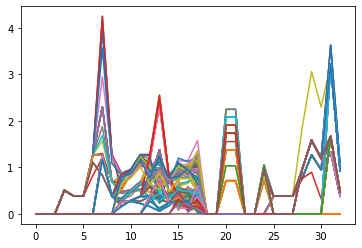

In [15]:
# Plot nodal unserved load at different node
node = range(nB)
for i in P_bus_shed_set:
      plt.plot(node, i)

plt.show()

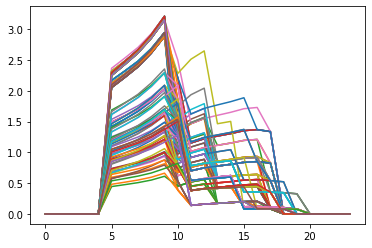

In [16]:
# Plot system unserved load at different t
t = range(nT)
for i in P_system_shed_set:
      plt.plot(t, i)

plt.show()

In [17]:
# Save these files to .csv
P_bus_shed_set2 = np.zeros((len(tripped_lines_set), nB))
P_system_shed_set2 = np.zeros((len(tripped_lines_set), nT))
for i in range(len(P_bus_shed_set)):
      for j in range(len(P_bus_shed_set[i])):
            P_bus_shed_set2[i,j] = P_bus_shed_set[i][j]

for i in range(len(tripped_lines_set)):
      for j in range(len(P_system_shed_set[i])):
            P_system_shed_set2[i,j] = P_system_shed_set[i][j]

P_bus_shed_set_df = pd.DataFrame(P_bus_shed_set2)
P_system_shed_set_df = pd.DataFrame(P_system_shed_set2)
P_bus_shed_set_df.to_csv('P_bus_shed_set_noMER.csv', index= False)
P_system_shed_set_df.to_csv('P_system_shed_set_noMER.csv', index= False)